In [28]:
import pandas as pd
from matplotlib import pyplot as plt
import glob

path = "/home/th3h04x/Documents/ml/heatblaster/Payloads/"

def combine_all_payloads(path : str):

    payloads = []
    payload_filenames = glob.glob(f"{path}/*.txt")
    
    for file_name in payload_filenames:
        with open(file=file_name) as f :
            for l in f.readlines():
                payloads.append(l.strip())
    return payloads

all_payloads = combine_all_payloads(path)

df = pd.DataFrame(all_payloads , columns=["payloads"])


In [78]:
import string
import urllib
import re 

class PayloadSpecialFeatureExtractor:
    
    def __init__(self , payload_dataframe : pd.DataFrame , payloads_path : str = "Payloads/"):
        self.payload_dataframe = payload_dataframe
        self.payloads_path = payloads_path
        self.js_event_keywords = []
        self.html_tags = []
        self.sql_keywords = []
        self.get_features_info()
        
    def get_features_info(self):
        
        JS_EVENTS_FILE_PATH = "keywords/js_events.txt"
        HTML_TAGS_FILE_PATH = "keywords/html_tags.txt"
        SQL_KEYWORDS_PATH = "keywords/sql_keywords.txt"
        
        #js events 
        with open(self.payloads_path+JS_EVENTS_FILE_PATH) as f:
            for l in f.readlines():
                self.js_event_keywords.append(l.strip().lower())
        
        #html tags
        with open(self.payloads_path+HTML_TAGS_FILE_PATH) as f:
            for l in f.readlines():
                self.html_tags.append(l.strip().lower())
        
        #sql keywords
        with open(self.payloads_path+SQL_KEYWORDS_PATH) as f:
            for l in f.readlines():
                self.sql_keywords.append(l.strip().lower())
#         print(self.html_tags)
#         print(self.js_event_keywords)
        
    def fit(self):

        self.payload_dataframe["length"] = self.payload_dataframe["payloads"].apply(lambda payload : self.extract_payload_length(payload)) 
        self.payload_dataframe["nonprintable_keywords"] = self.payload_dataframe["payloads"].apply(lambda payload : self.extract_nonprintable_keywords(payload)) 
        self.payload_dataframe["special_chars"] = self.payload_dataframe["payloads"].apply(lambda payload : self.extract_special_chars(payload)) 
        self.payload_dataframe["punctuation_chars"] = self.payload_dataframe["payloads"].apply(lambda payload : self.extract_punctuation_chars(payload)) 
        self.payload_dataframe["js_events"] = self.payload_dataframe["payloads"].apply(lambda payload : self.extract_js_events(payload))
        self.payload_dataframe["html_tags"] = self.payload_dataframe["payloads"].apply(lambda payload : self.extract_html_tags(payload)) 
        self.payload_dataframe["sql_keywords"] = self.payload_dataframe["payloads"].apply(lambda payload : self.extract_sql_keywords(payload)) 
        self.payload_dataframe["percentage_count"] = self.payload_dataframe["payloads"].apply(lambda payload : self.percentage_count(payload))
        self.payload_dataframe["spaces_count"] = self.payload_dataframe["payloads"].apply(lambda payload : self.spaces_count(payload) )

    def extract_special_chars(self , payload : str) -> int:
        count = 0 
        for c in payload:
            if c in string.punctuation:
                count += 1
        return count
    
    def extract_nonprintable_keywords(self , payload : str) -> int:    
        count = 0 
        for c in payload:
            if c not in string.printable:
                count += 1
        return count

    def extract_punctuation_chars(self , payload ):
        count = 0
        for c in payload:
            if c in string.punctuation:
                count += 1
        return count 

    def extract_js_events(self , payload : str):
        count = 0
        for word in payload.split():
            for event in self.js_event_keywords:
                if event.lower() in word.lower():
                    count += 1
                    
        return count 
    
    def extract_html_tags(self , payload : str):
        count = 0
        
        for word in payload.split():
            word = urllib.parse.unquote(word).lower()
            for tag in self.html_tags:
                a = f""
                if re.search(f".*(%3C|<).*{tag.lower()}.*(>|%3E).*" , word):
                    count += 1
                
        return count 
    
    def extract_sql_keywords(self , payload : str):
        count = 0
        
        for word in payload.split():
            word = urllib.parse.unquote(word).lower()
            for sql_word in self.sql_keywords:
                if sql_word in word:
                    count += 1
                    
        return count
    
    def extract_payload_length(self,payload : str) -> int:
        return len(payload)
    
    def percentage_count(self , payload : str) -> int:
        count = 0
        
        for c in payload:
            if c == "%":
                count += 1
        return count 
    
    def spaces_count(self , payload : str ) -> str :
        count = 0 
        for c in payload:
            if c == " ":
                count += 1
        return count

obj = PayloadSpecialFeatureExtractor(df)
obj.fit()
# df

In [79]:
# df["is_malicious"] = 1
df.describe()
df.to_csv("build/malicious_payloads.csv")

Properties of feature: sql_keywords
count    22405.000000
mean         1.689846
std          1.288048
min          0.000000
25%          1.000000
50%          2.000000
75%          2.000000
max         28.000000
Name: sql_keywords, dtype: float64


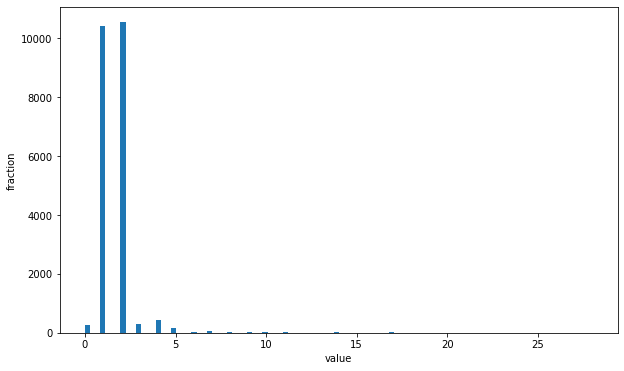

In [80]:
p = df.iloc[22403]["payloads"]

p.split()
def plot_feature_distribution(features):
    
    print('Properties of feature: ' + features.name)
    print(features.describe())
    f, ax = plt.subplots(1, figsize=(10, 6))
    ax.hist(features, bins=100)
    ax.set_xlabel('value')
    ax.set_ylabel('fraction')
    
    plt.show()

plot_feature_distribution(df["sql_keywords"])

In [81]:
#normal http requests query dataset preparation

import numpy as np

google_trends_df = pd.read_csv("datasets/trends.csv")

normal_query = google_trends_df[["query"]]
normal_query_df = normal_query.rename({"query":"payloads"},axis=1)

normal_query_obj = PayloadSpecialFeatureExtractor(normal_query_df)
normal_query_obj.fit()
normal_query_df.to_csv("build/normal_payloads.csv")